# Credit card fraud detection

### Exploring the credit card transaction data to learn a model for anomalies. 
### Key concept: handling skewed data.

#### Author: Sushant N. More

#### Revision history: 

October 20, 2017: Started writing

Borrows elements from the [this notebook](https://www.kaggle.com/joparga3/in-depth-skewed-data-classif-93-recall-acc-now/notebook) on Kaggle

See the description for data [here](https://www.kaggle.com/dalpozz/creditcardfraud)


### Brief summary:

Logistic regression and support vector machine models are trained on a highly skewed data. This is accomplished through resampling (specifically undersampling). The parameters of the models are chosen through KFold cross validation to give a high recall accuracy.  

For unseen data, logistic regression and SVM both give over 90% recall accuracy, with SVM doing slightly better. 

The notebook also does the ROC analysis and the looks at precision recall curves as a function of threshold.

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

%matplotlib inline

Importing the data

In [31]:
df = pd.read_csv('./creditcard.csv')

In [32]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


As described here V1 through V28 are the obtained through PCA.
The only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-senstive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.



Data exploration is in the order

In [33]:
df['Time'].head(10)

0    0.0
1    0.0
2    1.0
3    1.0
4    2.0
5    2.0
6    4.0
7    7.0
8    7.0
9    9.0
Name: Time, dtype: float64

So, time just monotonically increases

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
Time      284807 non-null float64
V1        284807 non-null float64
V2        284807 non-null float64
V3        284807 non-null float64
V4        284807 non-null float64
V5        284807 non-null float64
V6        284807 non-null float64
V7        284807 non-null float64
V8        284807 non-null float64
V9        284807 non-null float64
V10       284807 non-null float64
V11       284807 non-null float64
V12       284807 non-null float64
V13       284807 non-null float64
V14       284807 non-null float64
V15       284807 non-null float64
V16       284807 non-null float64
V17       284807 non-null float64
V18       284807 non-null float64
V19       284807 non-null float64
V20       284807 non-null float64
V21       284807 non-null float64
V22       284807 non-null float64
V23       284807 non-null float64
V24       284807 non-null float64
V25       284807 non-null float64
V26  

We find that no NULL values are present.

Just taking a look at the purchase amount to get a feel for values

In [35]:
df.loc[:,'Amount'].head()

0    149.62
1      2.69
2    378.66
3    123.50
4     69.99
Name: Amount, dtype: float64

In [36]:
df['Amount'].describe()

count    284807.000000
mean         88.349619
std         250.120109
min           0.000000
25%           5.600000
50%          22.000000
75%          77.165000
max       25691.160000
Name: Amount, dtype: float64

In [37]:
df['Class'].value_counts()

0    284315
1       492
Name: Class, dtype: int64

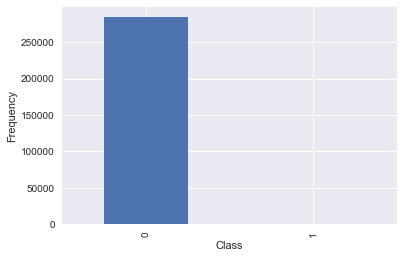

In [9]:
df['Class'].value_counts().plot(kind = 'bar')
plt.xlabel('Class')
plt.ylabel('Frequency')

** Highly skewed **

There are two things to keep in mind when dealing with skewed data

1. Accuracy is no longer a good metric.  (A model which predicts y = 0, will be highly accurate too!). So, we need to change the accuracy metric to some thing like F1 score

2. Try to restore the balance by resampling.  This has two components. 

(i) Oversampling: add copies of the under-represented class (works better when dataset small)

(ii) Undersampling: Delete instances from the over-represented class (works better when dataset large)

Another popular approach goes by the name SMOTE---Synthetic minority oversampling technique. In SMOTE the oversampling approach is not by replicating minority class but constructing new minority class data instance via an algorithm.

Note: the resampling methods are still in the spirit of supervised learning.  Another approach to try is the anomaly detection algorithm where we build the (joint) probability distribution for the features.  The idea is that the features occur in the tail.  The threshold \epislon can be chosen by cross validation.

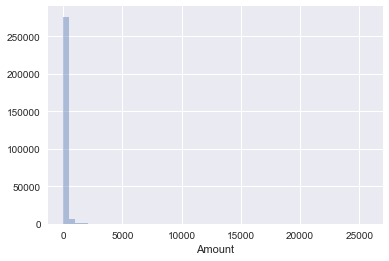

In [45]:
sns.distplot(df['Amount'], kde = False)

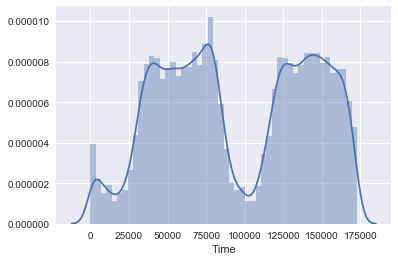

In [46]:
sns.distplot(df['Time'])

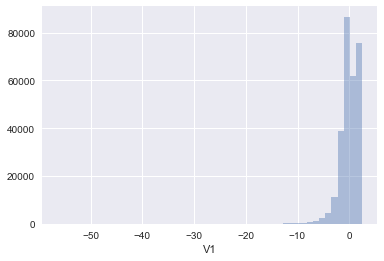

In [47]:
sns.distplot(df['V1'], kde = False)

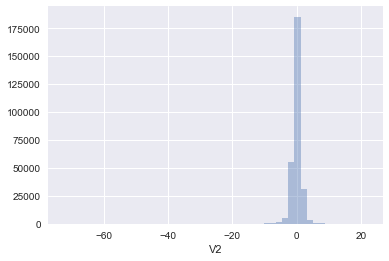

In [48]:
sns.distplot(df['V2'], kde = False)

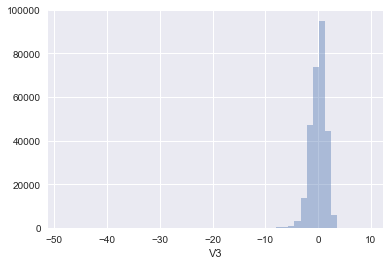

In [49]:
sns.distplot(df['V3'], kde = False)

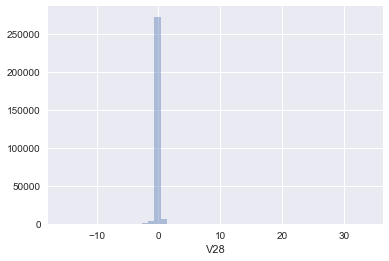

In [50]:
sns.distplot(df['V28'], kde = False)

Interesting to note that the features V1 through V28 are mostly centered around zero. 

In [51]:
df['V11'].describe()

count    2.848070e+05
mean     9.170318e-16
std      1.020713e+00
min     -4.797473e+00
25%     -7.624942e-01
50%     -3.275735e-02
75%      7.395934e-01
max      1.201891e+01
Name: V11, dtype: float64

Normalize the Time and the Amount feature to fall in line with the V's. 

In [52]:
df['Amount'].values.reshape(-1, 1)

array([[ 149.62],
       [   2.69],
       [ 378.66],
       ..., 
       [  67.88],
       [  10.  ],
       [ 217.  ]])

In [53]:
np.shape(df['Amount'].values.reshape(-1, 1))

(284807, 1)

Use reshape to get the amount column in the row form. The -1 entry tells numpy to figure out the length of that dimension. 

In [54]:
from sklearn.preprocessing import StandardScaler

df['normAmount'] = StandardScaler().fit_transform(df['Amount'].values.reshape(-1,1))
df['normTime'] = StandardScaler().fit_transform(df['Time'].values.reshape(-1,1))

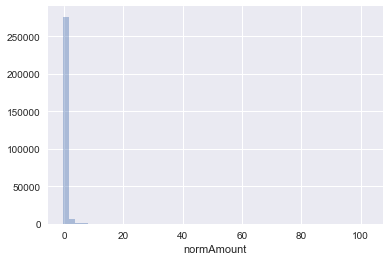

In [55]:
sns.distplot(df['normAmount'], kde = False)

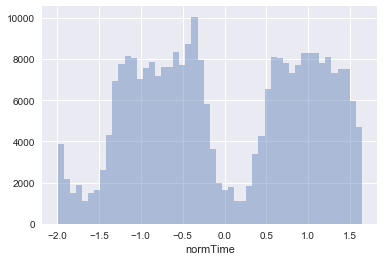

In [56]:
sns.distplot(df['normTime'], kde = False)

In [57]:
dfMod = df.drop(['Time','Amount'], axis = 1)

In [58]:
dfMod.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V22,V23,V24,V25,V26,V27,V28,Class,normAmount,normTime
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,0.244964,-1.996583
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,-0.342475,-1.996583
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,1.160686,-1.996562
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,0.140534,-1.996562
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,-0.073403,-1.996541


Let's look at the fraud and normal transactions separately

In [59]:
FraudTransaction = dfMod[dfMod['Class'] == 1]
NormalTransaction = dfMod[dfMod['Class'] == 0]

Interested in seeing if there is there is a correlation between the amount and the fraud transaction

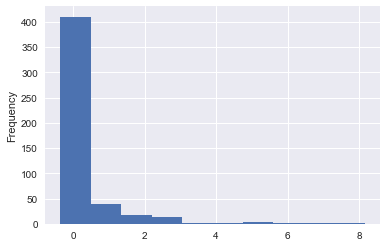

In [60]:
FraudTransaction['normAmount'].plot.hist()

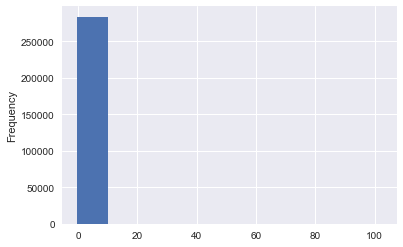

In [61]:
NormalTransaction['normAmount'].plot.hist()

In [62]:
np.sort(NormalTransaction['normAmount'])

array([  -0.35322939,   -0.35322939,   -0.35322939, ...,   75.25058053,
         78.23527182,  102.36224271])

So, fraud transactions where done for both small and large amount. Next look at the time

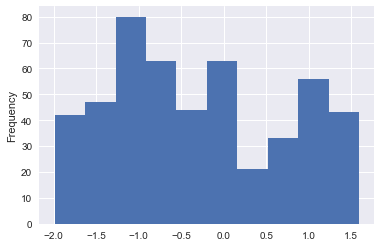

In [63]:
FraudTransaction['normTime'].plot.hist()

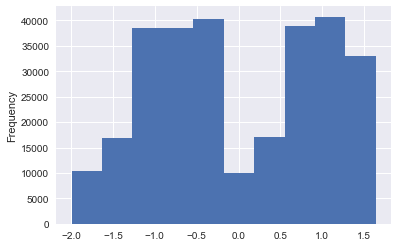

In [64]:
NormalTransaction['normTime'].plot.hist()

Again, the same kind of distribution for fraud vs. normal

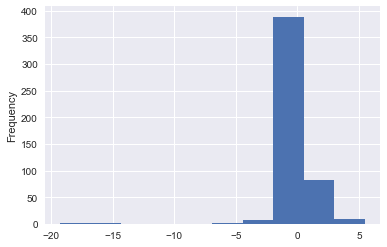

In [65]:
FraudTransaction['V23'].plot.hist()

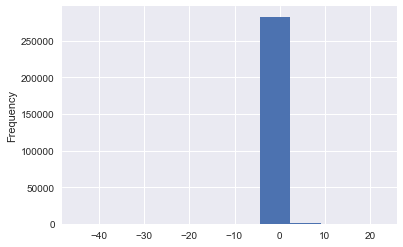

In [66]:
NormalTransaction['V23'].plot.hist()

In [67]:
np.sort(NormalTransaction['V23'])

array([-44.8077352 , -36.66600007, -32.828995  , ...,  20.8033441 ,
        22.08354487,  22.52841169])

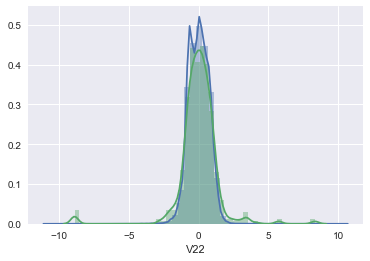

In [68]:
sns.distplot(dfMod['V22'][dfMod['Class'] == 0])
sns.distplot(dfMod['V22'][dfMod['Class'] == 1])

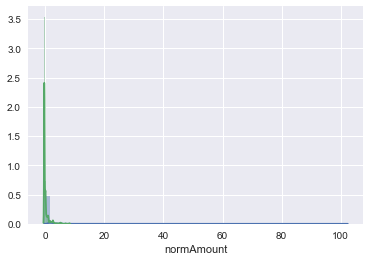

In [69]:
sns.distplot(dfMod['normAmount'][dfMod['Class'] == 0])
sns.distplot(dfMod['normAmount'][dfMod['Class'] == 1])

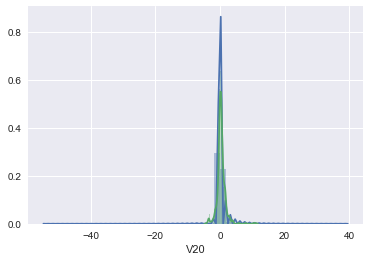

In [70]:
sns.distplot(dfMod['V20'][dfMod['Class'] == 0])
sns.distplot(dfMod['V20'][dfMod['Class'] == 1])

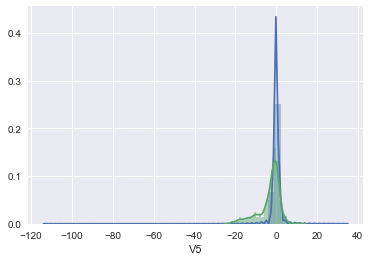

In [71]:
sns.distplot(dfMod['V5'][dfMod['Class'] == 0])
sns.distplot(dfMod['V5'][dfMod['Class'] == 1])

Looking at the distribution of few randomly selected features for the normal and the fraud cases, we can convince ourselves that in the fraud cases, features seem to take extreme values. 

Time column is just the chronological difference between the first transaction and the next. Can't see how it can affect the Fraud analysis.  Drop it. 

In [72]:
dfMod.columns

Index([u'V1', u'V2', u'V3', u'V4', u'V5', u'V6', u'V7', u'V8', u'V9', u'V10',
       u'V11', u'V12', u'V13', u'V14', u'V15', u'V16', u'V17', u'V18', u'V19',
       u'V20', u'V21', u'V22', u'V23', u'V24', u'V25', u'V26', u'V27', u'V28',
       u'Class', u'normAmount', u'normTime'],
      dtype='object')

In [73]:
dfMod = dfMod.drop('normTime', axis = 1)

In [74]:
dfMod.columns

Index([u'V1', u'V2', u'V3', u'V4', u'V5', u'V6', u'V7', u'V8', u'V9', u'V10',
       u'V11', u'V12', u'V13', u'V14', u'V15', u'V16', u'V17', u'V18', u'V19',
       u'V20', u'V21', u'V22', u'V23', u'V24', u'V25', u'V26', u'V27', u'V28',
       u'Class', u'normAmount'],
      dtype='object')

Now, let's seprate the class column from all other features. 

In [75]:
X = dfMod.loc[:, dfMod.columns != 'Class']
y = dfMod.loc[:, dfMod.columns == 'Class']

In [76]:
X.columns

Index([u'V1', u'V2', u'V3', u'V4', u'V5', u'V6', u'V7', u'V8', u'V9', u'V10',
       u'V11', u'V12', u'V13', u'V14', u'V15', u'V16', u'V17', u'V18', u'V19',
       u'V20', u'V21', u'V22', u'V23', u'V24', u'V25', u'V26', u'V27', u'V28',
       u'normAmount'],
      dtype='object')

In [77]:
y.head()

,Class
0,0
1,0
2,0
3,0
4,0


In [78]:
FraudTransaction.shape

(492, 31)

In [79]:
NormalTransaction.shape

(284315, 31)

In [80]:
X.shape

(284807, 29)

In [81]:
numberFraud = FraudTransaction.shape[0]

In [82]:
FraudTransactionModX = FraudTransaction.drop(['normTime', 'Class'], axis = 1)

In [83]:
FraudTransactionModX.shape

(492, 29)

In [84]:
NormalTransactionModX = NormalTransaction.drop(['normTime', 'Class'], axis = 1)

In [85]:
NormalTransactionModX.shape

(284315, 29)

In [86]:
NormalTransactionModY = NormalTransaction['Class']

In [87]:
NormalTransactionModY.head()

0    0
1    0
2    0
3    0
4    0
Name: Class, dtype: int64

In [88]:
FraudTransactionModY = FraudTransaction['Class']

In [89]:
dfMod.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Class,normAmount
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,0.244964
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,-0.342475
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,1.160686
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,0.140534
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,-0.073403


In [90]:
FraudTransactionModX.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,normAmount
541,-2.312227,1.951992,-1.609851,3.997906,-0.522188,-1.426545,-2.537387,1.391657,-2.770089,-2.772272,...,0.126911,0.517232,-0.035049,-0.465211,0.320198,0.044519,0.177840,0.261145,-0.143276,-0.353229
623,-3.043541,-3.157307,1.088463,2.288644,1.359805,-1.064823,0.325574,-0.067794,-0.270953,-0.838587,...,2.102339,0.661696,0.435477,1.375966,-0.293803,0.279798,-0.145362,-0.252773,0.035764,1.761758
4920,-2.303350,1.759247,-0.359745,2.330243,-0.821628,-0.075788,0.562320,-0.399147,-0.238253,-1.525412,...,-0.430022,-0.294166,-0.932391,0.172726,-0.087330,-0.156114,-0.542628,0.039566,-0.153029,0.606031
6108,-4.397974,1.358367,-2.592844,2.679787,-1.128131,-1.706536,-3.496197,-0.248778,-0.247768,-4.801637,...,-0.171608,0.573574,0.176968,-0.436207,-0.053502,0.252405,-0.657488,-0.827136,0.849573,-0.117342
6329,1.234235,3.019740,-4.304597,4.732795,3.624201,-1.357746,1.713445,-0.496358,-1.282858,-2.447469,...,0.009061,-0.379068,-0.704181,-0.656805,-1.632653,1.488901,0.566797,-0.010016,0.146793,-0.349231


In [91]:
dfMod.iloc[541,1:4]

V2    1.951992
V3   -1.609851
V4    3.997906
Name: 541, dtype: float64

In [92]:
FraudTransactionModX.sample(n= 2)

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,normAmount
191544,0.054682,1.856500,-4.075451,4.100098,-0.800931,-0.292502,-2.317431,1.189747,-0.786238,-3.906746,...,0.509559,0.618248,0.800932,0.130016,0.288946,-0.366658,0.030307,0.431182,0.110698,-0.029784
150668,-10.632375,7.251936,-17.681072,8.204144,-10.166591,-4.510344,-12.981606,6.783589,-4.659330,-14.924655,...,-0.810146,2.715357,0.695603,-1.138122,0.459442,0.386337,0.522438,-1.416604,-0.488307,0.400490


In [93]:
dfMod.iloc[102445,1:4]

V2    12.785971
V3    -9.906650
V4     3.320337
Name: 102445, dtype: float64

Sample works as expected

We will now jump into undersampling. Specifically, we will choose at random numberFraud examples from the Normal transaction data set. Ideally, we should do this random selection multiple times and take an average of results. But will leave it for later. There is no reason to believe that things will change drastically depending on the random choice. 

In [94]:
underSampleNormalX = NormalTransactionModX.sample(n = numberFraud)

In [95]:
underSampleNormalX.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,normAmount
110184,-1.066843,0.156848,1.169319,-2.986768,-0.612956,0.073655,-0.265748,0.130869,-1.963688,1.866204,...,0.152191,-0.482955,-0.625627,-0.194579,-0.899299,0.040963,-0.538297,0.121663,-0.224320,-0.241283
12662,1.186488,-0.249223,1.032612,-0.571891,-0.873586,-0.281131,-0.663373,-0.032737,2.955477,-1.527880,...,-0.116959,-0.117560,0.215653,-0.015491,0.063980,0.432840,-0.699871,0.087647,0.029430,-0.305852
107630,-1.787242,0.227820,0.736906,-1.406726,-1.527773,-0.104907,-1.347567,1.229743,-0.904559,-0.096175,...,-0.380987,0.571351,1.431000,0.037344,0.280040,-0.236640,-0.292084,-0.803056,-0.392232,-0.316967
153610,1.948870,-1.267213,-3.205275,-1.568744,2.144763,3.106998,-0.508760,0.481979,0.535356,0.389533,...,0.265310,0.152835,0.360000,-0.088403,0.708016,0.321557,-0.030376,-0.093369,-0.063850,0.284026
78064,0.946928,-0.144497,0.133049,1.094965,-0.062093,0.145908,0.078642,0.093164,-0.226857,0.144769,...,0.067842,0.194871,0.334861,-0.232244,-0.298750,0.563724,-0.259578,0.006746,0.024784,0.128140


In [96]:
underSampleNormalX.iloc[0,0]

-1.0668427337338802

In [97]:
underSampleNormalY = NormalTransactionModY.sample(n = numberFraud)

In [98]:
underSampleNormPlusFraudX = pd.concat([underSampleNormalX, FraudTransactionModX])

In [99]:
underSampleNormPlusFraudX.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,normAmount
110184,-1.066843,0.156848,1.169319,-2.986768,-0.612956,0.073655,-0.265748,0.130869,-1.963688,1.866204,...,0.152191,-0.482955,-0.625627,-0.194579,-0.899299,0.040963,-0.538297,0.121663,-0.224320,-0.241283
12662,1.186488,-0.249223,1.032612,-0.571891,-0.873586,-0.281131,-0.663373,-0.032737,2.955477,-1.527880,...,-0.116959,-0.117560,0.215653,-0.015491,0.063980,0.432840,-0.699871,0.087647,0.029430,-0.305852
107630,-1.787242,0.227820,0.736906,-1.406726,-1.527773,-0.104907,-1.347567,1.229743,-0.904559,-0.096175,...,-0.380987,0.571351,1.431000,0.037344,0.280040,-0.236640,-0.292084,-0.803056,-0.392232,-0.316967
153610,1.948870,-1.267213,-3.205275,-1.568744,2.144763,3.106998,-0.508760,0.481979,0.535356,0.389533,...,0.265310,0.152835,0.360000,-0.088403,0.708016,0.321557,-0.030376,-0.093369,-0.063850,0.284026
78064,0.946928,-0.144497,0.133049,1.094965,-0.062093,0.145908,0.078642,0.093164,-0.226857,0.144769,...,0.067842,0.194871,0.334861,-0.232244,-0.298750,0.563724,-0.259578,0.006746,0.024784,0.128140


In [100]:
underSampleNormPlusFraudX.tail()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,normAmount
279863,-1.927883,1.125653,-4.518331,1.749293,-1.566487,-2.010494,-0.882850,0.697211,-2.064945,-5.587794,...,1.252967,0.778584,-0.319189,0.639419,-0.294885,0.537503,0.788395,0.292680,0.147968,1.206024
280143,1.378559,1.289381,-5.004247,1.411850,0.442581,-1.326536,-1.413170,0.248525,-1.127396,-3.232153,...,0.226138,0.370612,0.028234,-0.145640,-0.081049,0.521875,0.739467,0.389152,0.186637,-0.350191
280149,-0.676143,1.126366,-2.213700,0.468308,-1.120541,-0.003346,-2.234739,1.210158,-0.652250,-3.463891,...,0.247968,0.751826,0.834108,0.190944,0.032070,-0.739695,0.471111,0.385107,0.194361,-0.041818
281144,-3.113832,0.585864,-5.399730,1.817092,-0.840618,-2.943548,-2.208002,1.058733,-1.632333,-5.245984,...,0.306271,0.583276,-0.269209,-0.456108,-0.183659,-0.328168,0.606116,0.884876,-0.253700,0.626302
281674,1.991976,0.158476,-2.583441,0.408670,1.151147,-0.096695,0.223050,-0.068384,0.577829,-0.888722,...,-0.017652,-0.164350,-0.295135,-0.072173,-0.450261,0.313267,-0.289617,0.002988,-0.015309,-0.183191


In [101]:
dfMod.loc[281144, 'Class']

1

In [102]:
underSampleNormPlusFraudX.shape

(984, 29)

In [103]:
underSampleNormPlusFraudY = pd.concat([underSampleNormalY, FraudTransactionModY])

In [104]:
underSampleNormPlusFraudY.shape

(984,)

** Splitting data into train and test sets **

In [106]:
from sklearn.model_selection import train_test_split

In [107]:
trainUnderSampleX, testUnderSampleX, trainUnderSampleY, testUnderSampleY \
    = train_test_split(underSampleNormPlusFraudX, underSampleNormPlusFraudY, test_size = 0.3) 

In [108]:
print("Number transactions train dataset: ", len(trainUnderSampleX))
print("Number transactions test dataset: ", len(testUnderSampleX))
print("Total number of transactions: ", len(trainUnderSampleX)+len(testUnderSampleX))

('Number transactions train dataset: ', 688)
('Number transactions test dataset: ', 296)
('Total number of transactions: ', 984)


In [109]:
trainUnderSampleX.shape

(688, 29)

In [110]:
trainUnderSampleY.head(10)

56500     0
262423    0
149134    0
147268    0
154694    1
46171     0
138589    0
53521     0
282887    0
541       1
Name: Class, dtype: int64

In [111]:
testUnderSampleY.head(10)

6472      1
237426    1
6108      1
96929     0
142557    1
86485     0
122479    1
276566    0
263080    1
10690     1
Name: Class, dtype: int64

In [112]:
testUnderSampleY.value_counts()

0    149
1    147
Name: Class, dtype: int64

In [113]:
trainUnderSampleY.value_counts()

1    345
0    343
Name: Class, dtype: int64

Now we can go ahead and start fitting models. 

Before that let's review some concepts:

* Accuracy = (TP + TN) / total

* Precision = TP / (TP + FP)

* Recall = TP / (TP + FN)

In the credit card case, we want to minimize the False negatives (i.e., we don't want to miss flagging fradulent transactions). So in general we want the accuracy to be large.

In [164]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import KFold, cross_val_score

**KFold:**

Provides train/test indices to split data in train test sets. Split dataset into k consecutive folds (without shuffling).

Each fold is then used a validation set once while the k - 1 remaining fold form the training set.

In [119]:
fold = KFold(5, shuffle=False) 

In [120]:
fold

KFold(n_splits=5, random_state=None, shuffle=False)

In [137]:
fold.split(trainUnderSampleY)

<generator object split at 0x7f58fa7b4c80>

In [210]:
# different C parameters
CparamRange = [0.001, 0.005, 0.01, 0.1, 1, 10, 100, 1000]

In [211]:
resultsTable = pd.DataFrame(index = range(len(CparamRange),2), columns = ['Cparameter','MeanRecallScore', \
                                                                          'MeanPrecisionScore', 'MeanF1Score'])

In [212]:
resultsTableSVC = pd.DataFrame(columns = ['Cparameter','MeanRecallScoreSVC', \
                                                                          'MeanPrecisionScoreSVC', 'MeanF1ScoreSVC'])

In [213]:
range(len(CparamRange),2)

[]

In [162]:
resultsTableSVC

,CparameterSVC,MeanRecallScoreSVC,MeanPrecisionScoreSVC,MeanF1ScoreSVC


In [125]:
range(3,2)

[]

In [126]:
resultsTable['Cparameter'] = CparamRange

In [127]:
resultsTable

,Cparameter,MeanRecallScore,MeanPrecisionScore,MeanF1Score
0,0.001,NaN,NaN,NaN
1,0.005,NaN,NaN,NaN
2,0.010,NaN,NaN,NaN
3,0.100,NaN,NaN,NaN
4,1.000,NaN,NaN,NaN
5,10.000,NaN,NaN,NaN
6,100.000,NaN,NaN,NaN


 Enumerate is a built-in Python function. 
 It allows us to loop over something and have an automatic counter. Here is an example:

In [128]:
my_list = ['apple', 'banana', 'grapes', 'pear']
for c, value in enumerate(my_list, start = 2):
    print c, value

2 apple
3 banana
4 grapes
5 pear


In [129]:
enumerate(my_list)

In [146]:
for iterations, indices in enumerate(fold.split(trainUnderSampleX)):
    print len(indices[0]) 
    print len(indices[1]) 

550
138
550
138
550
138
551
137
551
137


In [152]:
indices[1]

array([551, 552, 553, 554, 555, 556, 557, 558, 559, 560, 561, 562, 563,
       564, 565, 566, 567, 568, 569, 570, 571, 572, 573, 574, 575, 576,
       577, 578, 579, 580, 581, 582, 583, 584, 585, 586, 587, 588, 589,
       590, 591, 592, 593, 594, 595, 596, 597, 598, 599, 600, 601, 602,
       603, 604, 605, 606, 607, 608, 609, 610, 611, 612, 613, 614, 615,
       616, 617, 618, 619, 620, 621, 622, 623, 624, 625, 626, 627, 628,
       629, 630, 631, 632, 633, 634, 635, 636, 637, 638, 639, 640, 641,
       642, 643, 644, 645, 646, 647, 648, 649, 650, 651, 652, 653, 654,
       655, 656, 657, 658, 659, 660, 661, 662, 663, 664, 665, 666, 667,
       668, 669, 670, 671, 672, 673, 674, 675, 676, 677, 678, 679, 680,
       681, 682, 683, 684, 685, 686, 687])

In [153]:
137*5

685

the k-fold will give 2 lists: train_indices = indices[0], test_indices = indices[1]

In [154]:
indices[0];

In [155]:
trainUnderSampleY.iloc[indices[0]].values

array([0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1,
       0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1,
       0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1,
       1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0,
       0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1,
       0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0,
       0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1,
       0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0,
       0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1,
       0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0,
       1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0,
       0, 0,

In [156]:
from sklearn.metrics import confusion_matrix, precision_recall_curve, auc,roc_auc_score, \
roc_curve, recall_score, classification_report, precision_score, f1_score 

In [214]:
j = 0
for Cparameter in CparamRange:
    print '------------------------------'
    print 'C value = ', Cparameter
    print '------------------------------'
    
    recallVal = []
    precisionVal = []
    F1scoreVal = []
    recallValSVC = []
    precisionValSVC = []
    F1scoreValSVC = []
    
    for iteration, indices in enumerate(fold.split(trainUnderSampleY), 1):
        
        # Call the logistic regression model with a certain C parameter
        lr = LogisticRegression(C = Cparameter, penalty = 'l2')
        svc = SVC(C = Cparameter)
        
        # Use the training data to fit the model. In this case, we use the portion of the fold to train the model
        # with indices[0]. We then predict on the portion assigned as the 'test cross validation' with indices[1]
        
        lr.fit(trainUnderSampleX.iloc[indices[0], :], trainUnderSampleY.iloc[indices[0]])
        svc.fit(trainUnderSampleX.iloc[indices[0], :], trainUnderSampleY.iloc[indices[0]])
        
        # Predict values using the test indices in the training data
        yPred = lr.predict(trainUnderSampleX.iloc[indices[1], :])
        yPredSVC = svc.predict(trainUnderSampleX.iloc[indices[1], :])
        
        recallval = recall_score(trainUnderSampleY.iloc[indices[1]], yPred)
        recallvalSVC = recall_score(trainUnderSampleY.iloc[indices[1]], yPredSVC)
        
        precisionval = precision_score(trainUnderSampleY.iloc[indices[1]], yPred)
        precisionvalSVC = precision_score(trainUnderSampleY.iloc[indices[1]], yPredSVC)
        
        F1scoreval = f1_score(trainUnderSampleY.iloc[indices[1]], yPred)
        F1scorevalSVC = f1_score(trainUnderSampleY.iloc[indices[1]], yPredSVC)
        
        recallVal.append(recallval)
        precisionVal.append(precisionval)
        F1scoreVal.append(F1scoreval)
        recallValSVC.append(recallvalSVC)
        precisionValSVC.append(precisionvalSVC)
        F1scoreValSVC.append(F1scorevalSVC)
        
        print 'Iteration', iteration, ': recall score = ', recallval, \
              ', precision score = ', precisionval, ', F1 score = ', F1scoreval
        print 'Iteration', iteration, ': recall score SVC = ', recallvalSVC, \
              ', precision score SVC = ', precisionvalSVC, ', F1 score SVC= ', F1scorevalSVC    
    
    resultsTable.loc[j, 'Cparameter'] = Cparameter
    resultsTable.loc[j, 'MeanRecallScore'] = np.mean(recallVal)
    resultsTable.loc[j, 'MeanPrecisionScore'] = np.mean(precisionVal)
    resultsTable.loc[j, 'MeanF1Score'] = np.mean(F1scoreVal)
    
    resultsTableSVC.loc[j, 'Cparameter'] = Cparameter
    resultsTableSVC.loc[j, 'MeanRecallScoreSVC'] = np.mean(recallValSVC)
    resultsTableSVC.loc[j, 'MeanPrecisionScoreSVC'] = np.mean(precisionValSVC)
    resultsTableSVC.loc[j, 'MeanF1ScoreSVC'] = np.mean(F1scoreValSVC)
    
    j += 1

------------------------------
C value =  0.001
------------------------------
Iteration 1 : recall score =  0.985714285714 , precision score =  0.945205479452 , F1 score =  0.965034965035
Iteration 1 : recall score SVC =  0.942857142857 , precision score SVC =  0.80487804878 , F1 score SVC=  0.868421052632
Iteration 2 : recall score =  0.96875 , precision score =  0.815789473684 , F1 score =  0.885714285714
Iteration 2 : recall score SVC =  1.0 , precision score SVC =  0.463768115942 , F1 score SVC=  0.633663366337
Iteration 3 : recall score =  0.985714285714 , precision score =  0.8625 , F1 score =  0.92
Iteration 3 : recall score SVC =  0.928571428571 , precision score SVC =  0.822784810127 , F1 score SVC=  0.872483221477
Iteration 4 : recall score =  1.0 , precision score =  0.818181818182 , F1 score =  0.9
Iteration 4 : recall score SVC =  1.0 , precision score SVC =  0.459854014599 , F1 score SVC=  0.63
Iteration 5 : recall score =  0.987179487179 , precision score =  0.916666666

In [215]:
resultsTable

,Cparameter,MeanRecallScore,MeanPrecisionScore,MeanF1Score
0,0.001,0.985472,0.871669,0.924273
1,0.005,0.944838,0.935673,0.939994
2,0.01,0.939124,0.952413,0.945485
3,0.1,0.921738,0.968479,0.944412
4,1,0.921738,0.953702,0.937146
5,10,0.919174,0.953702,0.93575
6,100,0.924278,0.951019,0.937156
7,1000,0.924522,0.948707,0.935922


Let's work with C = 0.005. It gives a good value for recall without making the precision too small. 

In [226]:
Cbest = 0.005

In [216]:
resultsTableSVC

,Cparameter,MeanRecallScoreSVC,MeanPrecisionScoreSVC,MeanF1ScoreSVC
0,0.001,0.774286,0.510257,0.600914
1,0.005,0.774286,0.510257,0.600914
2,0.01,0.805055,0.732999,0.674687
3,0.1,0.924278,0.894821,0.9089
4,1,0.933142,0.94339,0.937866
5,10,0.949138,0.922004,0.935203
6,100,0.947134,0.922356,0.934292
7,1000,0.947134,0.922356,0.934292


In [179]:
CbestSVC = 10.0

For SVC the best C value is 10. 

Use these C parameters to build the final model with the whole (undersampled) training dataset and predict the classes in test. 

Let's look at which kernel is better for SVC

In [221]:
svc = SVC(C = CbestSVC)               
svc.fit(trainUnderSampleX, trainUnderSampleY)
yPredSVC = svc.predict(testUnderSampleX)

svclinear = SVC(C = CbestSVC, kernel = 'linear')               
svclinear.fit(trainUnderSampleX, trainUnderSampleY)
yPredSVClinear = svclinear.predict(testUnderSampleX)

recallvalSVCRBF = recall_score(testUnderSampleY, yPredSVC)
precisionvalSVCRBF = precision_score(testUnderSampleY, yPredSVC)
f1scoreSVCRBF = f1_score(testUnderSampleY, yPredSVC)

recallvalSVClinear = recall_score(testUnderSampleY, yPredSVClinear)
precisionvalSVClinear = precision_score(testUnderSampleY, yPredSVClinear)
f1scoreSVClinear = f1_score(testUnderSampleY, yPredSVClinear)

In [222]:
recallvalSVCRBF, precisionvalSVCRBF, f1scoreSVCRBF 

(0.891156462585034, 0.89726027397260277, 0.89419795221843001)

In [223]:
recallvalSVClinear, precisionvalSVClinear, f1scoreSVClinear 

(0.88435374149659862, 0.94890510948905105, 0.91549295774647876)

The RBF kernel seems slightly better especially because we want high recall

In [245]:
lr = LogisticRegression(C = Cbest)
lr.fit(trainUnderSampleX, trainUnderSampleY)
yPredTest = lr.predict(testUnderSampleX)
svc = SVC(C = CbestSVC)
svc.fit(trainUnderSampleX, trainUnderSampleY)
yPredTestSVC = svc.predict(testUnderSampleX)

In [250]:
confMatrix = confusion_matrix(testUnderSampleY, yPredTest)
confMatrixSVC = confusion_matrix(testUnderSampleY, yPredTestSVC)

In [247]:
confMatrix

array([[133,  16],
       [ 15, 132]])

In [248]:
print 'Recall score on the test data: ', recall_score(testUnderSampleY, yPredTest)
print 'Precision score on the test data: ', precision_score(testUnderSampleY, yPredTest)
print 'F1 score on the test data: ', f1_score(testUnderSampleY, yPredTest)

Recall score on the test data:  0.897959183673
Precision score on the test data:  0.891891891892
F1 score on the test data:  0.894915254237


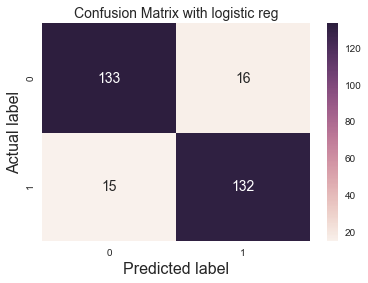

In [254]:
sns.heatmap(confMatrix, annot= True, fmt = '.0f', annot_kws={'size': 14})
plt.xlabel('Predicted label', fontsize = 16)
plt.ylabel('Actual label', fontsize = 16)
plt.title('Confusion Matrix with logistic reg', fontsize = 14)

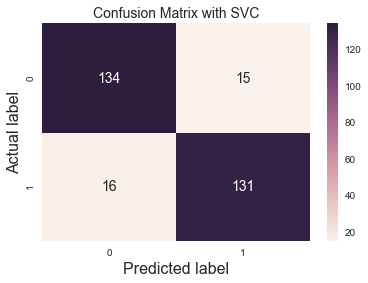

In [253]:
sns.heatmap(confMatrixSVC, annot= True, fmt = '.0f', annot_kws={'size': 14})
plt.xlabel('Predicted label', fontsize = 16)
plt.ylabel('Actual label', fontsize = 16)
plt.title('Confusion Matrix with SVC', fontsize = 14)

**The model offers about 90% recall accuracy on previously unseen data, which is a pretty good result for both logistic regression and SVM. Let's use our model on the full data**

In [255]:
NormalTransactionModX.shape

(284315, 29)

In [256]:
FraudTransactionModX.shape

(492, 29)

In [257]:
len(NormalTransactionModX)

284315

In [258]:
NormalPlusFraudX = pd.concat([NormalTransactionModX, FraudTransactionModX])
NormalPlusFraudY = pd.concat([NormalTransactionModY, FraudTransactionModY])

In [263]:
lr = LogisticRegression(C = Cbest)
lr.fit(trainUnderSampleX, trainUnderSampleY)
yPredFull = lr.predict(NormalPlusFraudX)
svc = SVC(C = CbestSVC)
svc.fit(trainUnderSampleX, trainUnderSampleY)
yPredFullSVC = svc.predict(NormalPlusFraudX)

In [264]:
print 'Recall score on the entire data: ', recall_score(NormalPlusFraudY, yPredFull)
print 'Precision score on the entire data: ', precision_score(NormalPlusFraudY, yPredFull)
print 'F1 score on the entire data: ', f1_score(NormalPlusFraudY, yPredFull)

Recall score on the entire data:  0.930894308943
Precision score on the entire data:  0.0250122876959
F1 score on the entire data:  0.0487156304845


In [268]:
confMatrixFull = confusion_matrix(NormalPlusFraudY, yPredFull)

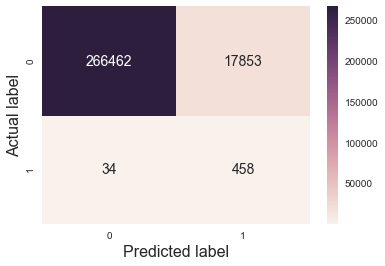

In [269]:
sns.heatmap(confMatrixFull, annot= True, fmt = '.0f', annot_kws={'size': 14})
plt.xlabel('Predicted label', fontsize = 16)
plt.ylabel('Actual label', fontsize = 16)

In [270]:
print 'Recall score on the entire data with SVC: ', recall_score(NormalPlusFraudY, yPredFullSVC)
print 'Precision score on the entire data with SVC: ', precision_score(NormalPlusFraudY, yPredFullSVC)
print 'F1 score on the entire data with SVC: ', f1_score(NormalPlusFraudY, yPredFullSVC)

Recall score on the entire data with SVC:  0.961382113821
Precision score on the entire data with SVC:  0.0214590327556
F1 score on the entire data with SVC:  0.0419810064791


In [271]:
confMatrixFullSVC = confusion_matrix(NormalPlusFraudY, yPredFullSVC)

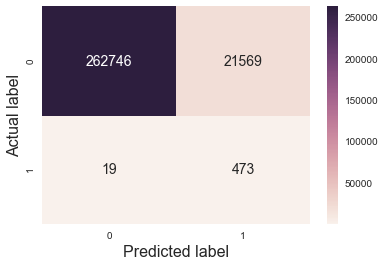

In [273]:
sns.heatmap(confMatrixFullSVC, annot= True, fmt = '.0f', annot_kws={'size': 14})
plt.xlabel('Predicted label', fontsize = 16)
plt.ylabel('Actual label', fontsize = 16)

** A large false positive rate, but a small false negative rate. **

Although decreasing FN is the most important. The next improvement on the model would be decreasing FP (we don't wanna irritate the customers). One possible way to do this (while keeping the FN rate low) is to employ feature engineering. This will involve looking at the features which are in the tail for normal transactions as well and engineering new features which drive these examples from tail into the body. 

Of course, the other way is to use the Anomaly detection algorithms which shall form basis of next notebook. 

### ROC: receiver operating characteristic curve

ROC plots the True positive rate vs. the false positive rate.

True positive rate: This is nothing but recall (TP / (TP + FN)) -- when it's actually yes, how often does it predict yes. 

False positive rate: When it's actually no, how often does it predict yes. (FP/ actual no = FP / (FP + TN))

ROC curve illustrates the diagnostic ability of a binary classifier system as its discrimination threshold is varied. Accuracy is measured by the area under the ROC curve. An area of 1 represents a perfect test; an area of 0.5 worthless test. 

roc_curve syntax is as follows:

sklearn.metrics.roc_curve(y_true, y_score, pos_label=None, sample_weight=None, drop_intermediate=True)

y_true: true binary labels in range {0, 1} or {-1, 1}

y_score: Target scores, can either be probability estimates of the positive class, confidence values, or non-thresholded measure of decisions (as returned by “decision_function” on some classifiers). 

In [274]:
lr = LogisticRegression(C = Cbest)
lr.fit(trainUnderSampleX, trainUnderSampleY)
yTestScore = lr.decision_function(testUnderSampleX.values)

fpr, tpr, threshold = roc_curve(testUnderSampleY, yTestScore)

In [275]:
yTestScore[:5]

array([ 3.79673383,  2.58563474,  5.68371432, -1.00333362, -0.39280765])

Decision function predicts confidence scores for samples.
The confidence score for a sample is the signed distance of that sample to the hyperplane. Therefore it can be negative.

In [276]:
fpr

array([ 0.        ,  0.        ,  0.00671141,  0.00671141,  0.01342282,
        0.01342282,  0.02013423,  0.02013423,  0.02684564,  0.02684564,
        0.03355705,  0.03355705,  0.04697987,  0.04697987,  0.06711409,
        0.06711409,  0.08053691,  0.08053691,  0.10738255,  0.10738255,
        0.12080537,  0.12080537,  0.1409396 ,  0.1409396 ,  0.14765101,
        0.14765101,  0.19463087,  0.19463087,  0.22818792,  0.22818792,
        0.24161074,  0.24161074,  0.26174497,  0.26174497,  0.28187919,
        0.28187919,  0.31543624,  0.31543624,  0.51006711,  0.51006711,
        0.5704698 ,  0.5704698 ,  0.88590604,  0.88590604,  1.        ])

In [277]:
threshold

array([  1.37006633e+01,   1.31031682e+00,   1.07588557e+00,
         9.97338000e-01,   9.41727236e-01,   6.96025068e-01,
         6.51762867e-01,   5.87740453e-01,   5.38818349e-01,
         5.24601208e-01,   4.82399474e-01,   4.35546720e-01,
         3.63742975e-01,   3.13581679e-01,   2.14062883e-01,
         1.90959667e-01,   1.24158935e-01,   5.94604105e-02,
         1.24793255e-02,  -2.00735104e-02,  -8.43607417e-02,
        -1.39653367e-01,  -1.85833363e-01,  -1.91770974e-01,
        -2.07365438e-01,  -2.13936709e-01,  -2.82926651e-01,
        -2.93544547e-01,  -3.32933663e-01,  -3.39682164e-01,
        -3.60252855e-01,  -3.66573656e-01,  -3.85589233e-01,
        -3.92807653e-01,  -4.04561960e-01,  -4.05136503e-01,
        -4.33692075e-01,  -4.46531191e-01,  -5.85543659e-01,
        -5.90108247e-01,  -6.33334632e-01,  -6.34473429e-01,
        -8.43418008e-01,  -8.46919002e-01,  -1.46012948e+00])

In [278]:
roc_auc = roc_auc_score(testUnderSampleY, yTestScore)

# Can also use the general area under the curve function: auc(fpr,tpr)

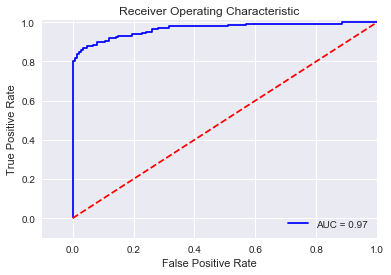

In [279]:
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.0])
plt.ylim([-0.1,1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Looks great.  Our model works fine. 

### Changing threshold

The predict_proba() method returns the probabilities for each class. The idea is that by changing the threshold to assign a record to class 1, we can control the precision and the recall.  

In [512]:
lr = LogisticRegression(C = Cbest)
lr.fit(trainUnderSampleX, trainUnderSampleY)
yPredUnderSampleProba = lr.predict_proba(testUnderSampleX)
yTestScore = lr.decision_function(testUnderSampleX)

thresholds = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]

Threshold =  0.1 , recall =  1.0 , precision =  0.533783783784 , f1_score =  0.696035242291
Threshold =  0.2 , recall =  1.0 , precision =  0.533783783784 , f1_score =  0.696035242291
Threshold =  0.3 , recall =  1.0 , precision =  0.533783783784 , f1_score =  0.696035242291
Threshold =  0.4 , recall =  1.0 , precision =  0.535593220339 , f1_score =  0.697571743929
Threshold =  0.5 , recall =  0.955696202532 , precision =  0.848314606742 , f1_score =  0.89880952381
Threshold =  0.6 , recall =  0.879746835443 , precision =  0.965277777778 , f1_score =  0.920529801325
Threshold =  0.7 , recall =  0.810126582278 , precision =  1.0 , f1_score =  0.895104895105
Threshold =  0.8 , recall =  0.778481012658 , precision =  1.0 , f1_score =  0.875444839858
Threshold =  0.9 , recall =  0.620253164557 , precision =  1.0 , f1_score =  0.765625


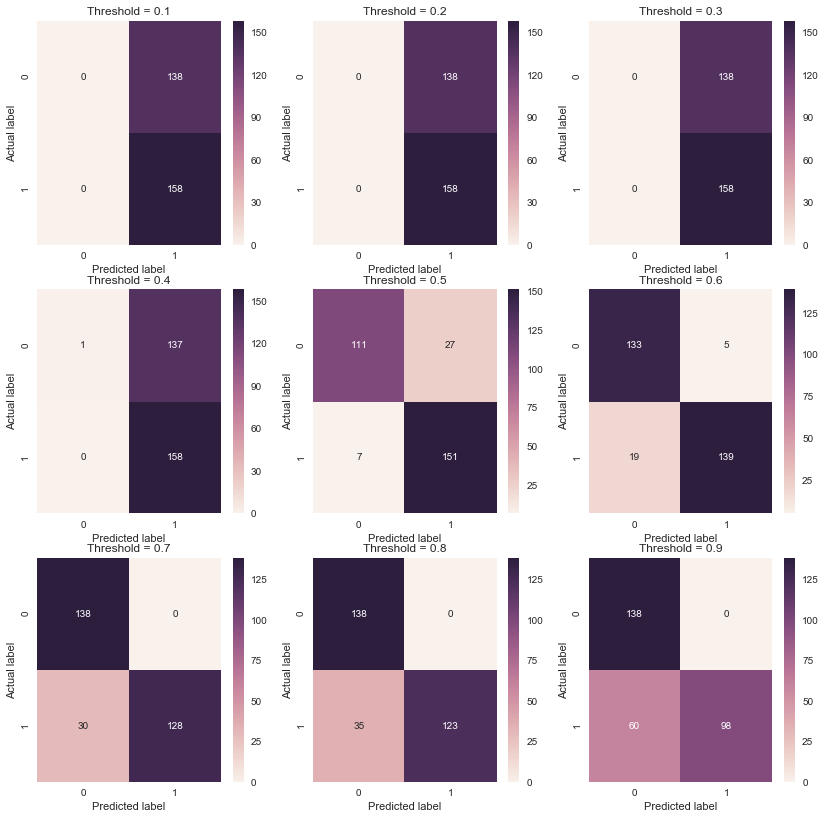

In [477]:
plt.figure(figsize = (14,14))

j = 1

for i in thresholds:
    
    yTestPred = yPredUnderSampleProba[:, 1] > i
    
    plt.subplot(3, 3, j)
    
    j += 1
    
    print 'Threshold = ', i, ', recall = ', recall_score(testUnderSampleY, yTestPred), \
          ', precision = ', precision_score(testUnderSampleY, yTestPred), \
          ', f1_score = ', f1_score(testUnderSampleY, yTestPred)
    
    sns.heatmap(confusion_matrix(testUnderSampleY, yTestPred), annot= True, fmt = '.0f')
    plt.xlabel('Predicted label')
    plt.ylabel('Actual label')
    plt.title('Threshold = %0.1f' %i)

It's clear that when the threshold is low, everything is classified as an anomaly. As threshold is steadily increased, more examples are transfered from "1" class to "0" class.  It's also clear that some examples are so anamolous that even with very large threshold, they are still classified as anamolous. 

Let's look at the precision recall curve which shows the value for precision and recall for different thresholds. 

The precision recall curve function from the from sklearn.metrics require y_true and probas_pred. 
The documentation says that probas_pred are the estimated probabilities or decision function. Below we test both.

The predict predict_proba method gives the probability for the class 0 and class 1. (Spits an array of size numberSample x 2). Of course the probabilities for class 0 and class 1 for each sample add to 1.

The decision function gives the confidence score -- signed distance of that sample to the hyperplane.

In [537]:
#yPredUnderSampleProba = lr.predict_proba(testUnderSampleX)
#yTestScore = lr.decision_function(testUnderSampleX)

pr, recall, thresh = precision_recall_curve(testUnderSampleY, yTestScore)
pr1, recall1, thresh1 = precision_recall_curve(testUnderSampleY, yPredUnderSampleProba[:,0])
#using the probability for getting 0
pr2, recall2, thresh2 = precision_recall_curve(testUnderSampleY, yPredUnderSampleProba[:,1])
#using the probability for getting 1. 

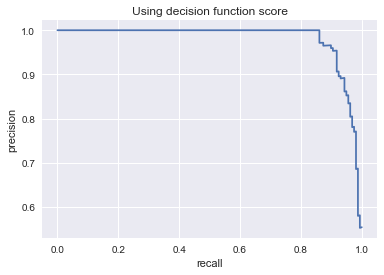

In [543]:
plt.plot(recall, pr)
plt.xlabel('recall')
plt.ylabel('precision')
plt.title('Using decision function score')

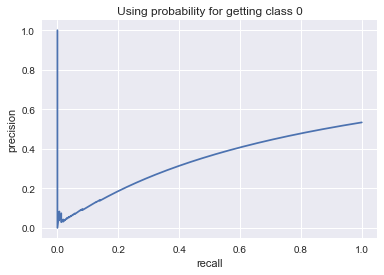

In [540]:
plt.plot(recall1, pr1)
plt.xlabel('recall')
plt.ylabel('precision')
plt.title('Using probability for getting class 0')

Evidently, using probability for class 0 as the score in the precision-recall function gives garbage answer. 

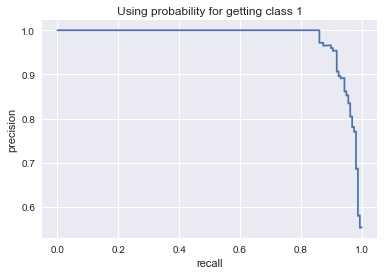

In [541]:
plt.plot(recall2, pr2)
plt.xlabel('recall')
plt.ylabel('precision')
plt.title('Using probability for getting class 1')

Same answer as by using the score from decision function.

Let's look at precision and recall as a function of threshold and precision.

In [523]:
pr.shape

(279,)

In [524]:
recall.shape

(279,)

In [525]:
thresh.shape

(278,)

In [526]:
testUnderSampleX.shape

(296, 29)

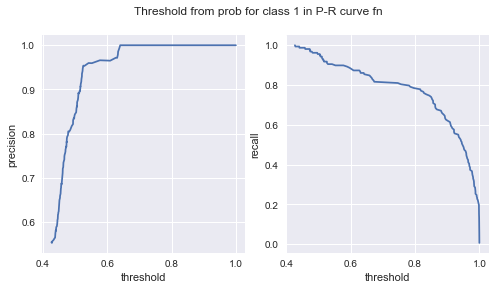

In [557]:
plt.figure(figsize = (8,4))
plt.subplot(1, 2, 1)
plt.plot(thresh2, pr2[0:len(pr2)-1])
plt.xlabel('threshold')
plt.ylabel('precision')
plt.subplot(1, 2, 2)
plt.plot(thresh2, recall2[0:len(recall2)-1])
plt.xlabel('threshold')
plt.ylabel('recall')
plt.suptitle('Threshold from prob for class 1 in P-R curve fn')

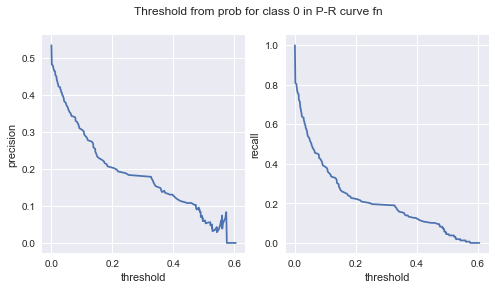

In [556]:
plt.figure(figsize = (8,4))
plt.subplot(1, 2, 1)
plt.plot(thresh1, pr1[0:len(pr1)-1])
plt.xlabel('threshold')
plt.ylabel('precision')
plt.subplot(1, 2, 2)
plt.plot(thresh1, recall1[0:len(recall1)-1])
plt.xlabel('threshold')
plt.ylabel('recall')
plt.suptitle('Threshold from prob for class 0 in P-R curve fn')

#### Obviously this is not right

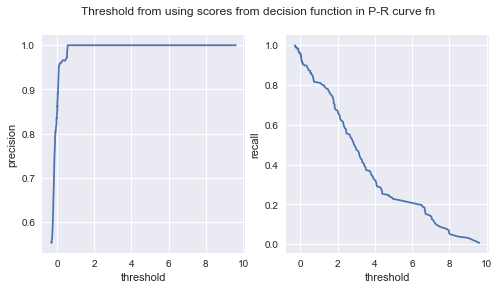

In [558]:
plt.figure(figsize = (8,4))
plt.subplot(1, 2, 1)
plt.plot(thresh, pr[0:len(pr)-1])
plt.xlabel('threshold')
plt.ylabel('precision')
plt.subplot(1, 2, 2)
plt.plot(thresh, recall[0:len(recall)-1])
plt.xlabel('threshold')
plt.ylabel('recall')
plt.suptitle('Threshold from using scores from decision function in P-R curve fn')

Threshold obtained from using the decision function scores in the precision_recall_curve function doesn't have the same interpretation as the threshold on probabilities.  